In [1]:
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt


## $\textcolor{green}{\text{CNN}}$
Convolutional Neural Network (CNN or ConvNet) is a specialized algorithm designed to work well with image recognition type of problems and it can be applied to other tasks such as Natural Language Processing, Speech Recognition or Recommendation Systems. CNN is able to extract features and patterns irrespective of their size, orientation or position.

The inspiration for CNN comes from actual structure of visual cortex in humans. Unlike MLP, CNN "perceives" image in smaller regions (mimicking Receptive Field) instead of looking at it pixel by pixel. Neurons in CNN layers are only conected to neurons that are in close proximity which adds efficiency. Moreover, this means we are taking into account proximity of pixels to each other which is completely ignored by MLP.

Here is general structure of CNN:

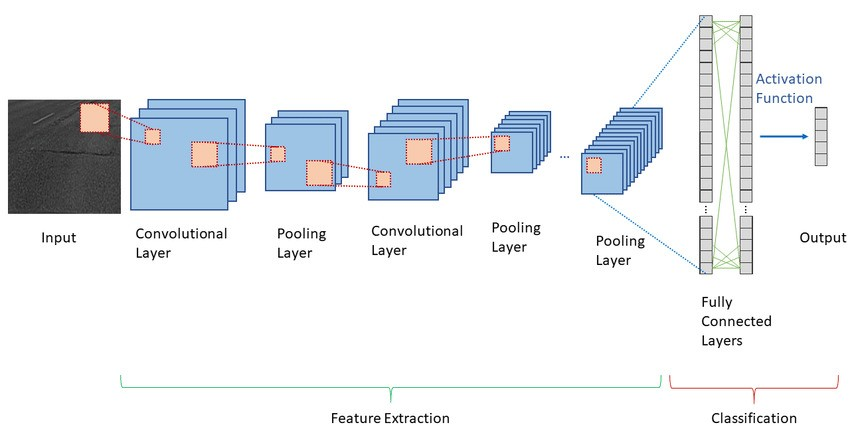

As you can see CNN consists of two parts: feature extraction part and classification part. Classification part is just MLP. So the new part is feature extraction. Feature extraction part consist of multiple Convolutional parts each of which consists of two layers: Convolutional Layer with Activation function (often ReLU) and Pooling Layer.


---

#### $\textcolor{blue}{\text{Convolutional Layer}}$
The best way to explain convolution is look at the following animation:

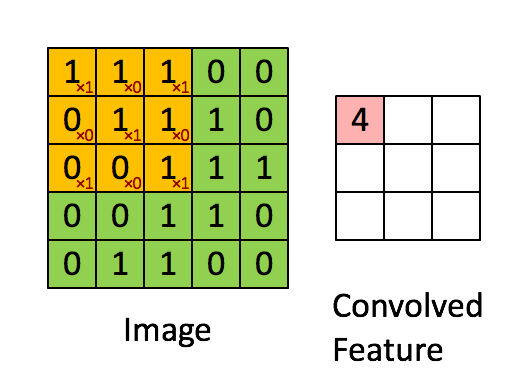

In this case we have 5x5x1 (Height x Width x Chanels) image (in green). We apply a 3x3 kernel to it (in yellow) starting in the top left corner and moving it 1 step (called Stride) from left to right, up to down to create a 3x3 convolutional layer (in red). To get the red values, we multiply kernel by the green part underneath element-wise and then add the result. This is followed by ReLU activation function to add non-linearity. Since color images generally have 3 chanels (RGB), in this case our kernel would be a 3-dim tensor (e.g. 3x3x3). Notice that our result ended up smaller the original image, so this comes with a certain dimensionality reduction as well.

Each kernel learns about particular feature, so we generally want more kernels. Therefore, normally we apply multiple kernels (Depth) and stack our convolutional layers in a 3-dim tensor.

Finally, we may add zero-padding to our convolution which affects dimensionality reduction. Zero padding is just adding zero pixels around our image. If we, for example, add one layer of zero pixels around the image, then we may keep the same dimension depending on stride. We may even increase dimension if we add more layers, so this is rarely done.

<div class="alert alert-block alert-warning"><b>Warning:</b> You do have to keep an eye on the sizes of your image, kernel, stride and padding as certain combinations can be illegal. For example, If we have a 4x4 image with 3x3 kernel, stride 2 and no padding, then you will not be able to move your kernel and cover all pixels.</div>
Generally, here is a way to calculate the size of convolutional layer (these values must be integers, so any hyperparameter that creates fractional values are illegal):

If we start with image of size $W_1 \times H_1 \times D_1$ and set number of kernels to $K$, size of kernel to $F$, stride to $S$ and padding layers to $P$, then our convolutional layer will have size $W_2 \times H_2 \times D_2$, where $$ W_2=\frac{W_1-F+2P}{S}+1, H_2=\frac{H_1-F+2P}{S}+1, D_2=K$$

So, for example, in our illegal example above $W_1=4, S=2, K=1, F=3$, so $W_2=(4-3+0)/2+1=1.5$, which is not an integer.

In our animated example, $W_1=5, S=1, K=1, F=3$, so $W_2=(5-3+0)/1+1=3$. Same for height. So, our convolutional layer is 3 by 3.


<div class="alert alert-block alert-info"><b>Note:</b>
Kernels are our parameters here which we will adjust based on back propagation in the future.</div>




---

#### $\textcolor{blue}{\text{Pooling}}$
The goal of Pooling layer is to pull the most significant features from convolutional layer which helps with dimensionality reduction and overfitting. This is done by condensing convolutional layer to a smaller tensor (this is similar to just scaling down an image). There are few ways to perform pooling. We will look at two common ones: Max Pooling and Average Pooling. In each case, we apply filter of certain size to each chanel, moving it from left to right, up to down with certain stride, each time agregating all values under the filter and either taking the largest one (Max Pooling) or average of all values (Average Pooling):

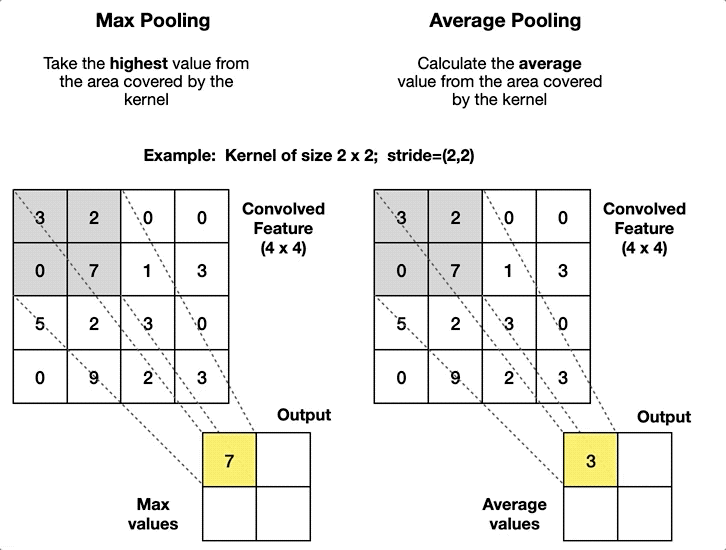



The stride doesn't have to equal to the size of filter, though you do want to make sure nothing is missed. The calculation for the dimensions of pooling layer are the same as for convolutional layer. So fo example, in animation above we have $W_1=4, F=2, S=2$, so $W_2=(4-2)/2+1=2$.

Sometimes, pooling layer can be dropped in favor of extra convolutional layer with larger stride.

---
## $\textcolor{green}{\text{Classification}}$
After the last Pooling Layer we apply flattening just like we did at the start of image recognition example with MLP. This is followed by a few fully connected layers (regular MLP with ReLU), and finally finished with the Softmax classification.

As with MLP we want to avoid overfitting. Most strategies we listed then (Dropout, Early Stopping, Regularization, Data Augmentation) are still applicable.

We will do two examples. In the first we will work with the same digits dataset as we did with MLP. In the second example, I will use color images.

#### $\textcolor{red}{\text{Example with digits dataset}}$


In [14]:
def get_acc_loss(model, loader):
    correct=0
    total=0
    for images, labels in loader:
        output=model(images)
        pred = output.data.max(1, keepdim=True)[1]
        total+=labels.shape[0]
        correct += pred.eq(labels.data.view_as(pred)).sum()
        loss=loss_func(output, labels)
    acc=100.*correct/total
    return acc, loss

def plot_acc_loss(train_acc,  train_loss, test_acc, test_loss, n_epochs):
    fig, ax= plt.subplots(1,2, figsize=(15,5))
    ax[0].plot(np.arange(1,n_epochs+1, 1), train_acc, color='blue')
    ax[0].plot(np.arange(1,n_epochs+1, 1), test_acc, color='red')
    ax[0].legend(['Train Accuracy', 'Test Accuracy'], loc='lower right')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Accuracy')
    
    ax[1].plot(np.arange(1,n_epochs+1, 1), train_loss, color='blue')
    ax[1].plot(np.arange(1,n_epochs+1, 1), test_loss, color='red')
    ax[1].legend(['Train Loss', 'Test Loss'], loc='lower right')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].set_title('Loss')
    
    plt.show()

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.RandomRotation(degrees=(-30, 30)),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])

In [4]:
trainset = datasets.MNIST('./', download=True, train=True, transform=transform)
testset = datasets.MNIST('./', download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

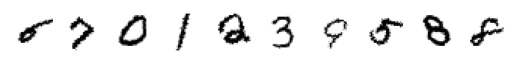

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

figure = plt.figure()
num_of_images = 10
for index in range(0, num_of_images):
    plt.subplot(1, 10, index+1)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

To create a convolutional layer, we use `nn.Conv2d`. For max pooling we will use `nn.MaxPool2d`. Note that for MaxPool2d, the default stride is equal to kernel size. We dont have to specify size of the layers, but we do need to keep track of it. Neat websites to keep track of sizes :
1. https://mecsimcalc.com/app/3444914/2_d_cnn_layer_output_size_calculator
2.  https://madebyollin.github.io/convnet-calculator/
3.   https://asiltureli.github.io/Convolution-Layer-Calculator/

In [6]:

class DigitCNN(nn.Module):
    
    def __init__(self):
        super(DigitCNN, self).__init__()
        self.flatten = nn.Flatten()
        self.convolution_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(5,5), stride=1, padding=0),   #in = 1x28x28; out = 16x24x24
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),      # in = 16x24x24:  out = 16x12x12
            nn.Dropout(0.2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=1, padding=0),   #in = 16x12x12; out = 32x10x10
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),      # in = 32x10x10:  out = 32x5x5
            nn.Dropout(0.2)
        )
        self.linear_stack=nn.Sequential(
            nn.Linear(32*5*5, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256,10)
        )

    def forward(self, x):
        x = self.convolution_stack(x)
        x=self.flatten(x)
        x=self.linear_stack(x)
        return x



In [7]:
model1=DigitCNN()

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=0.001, momentum =0.9, weight_decay=0.01)

In [8]:
n_epochs=3
train_loss = []
test_loss = []
train_acc=[]
test_acc=[]




In [9]:
for epoch in range(n_epochs):
    model1.train()
    for idx, (images, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        output = model1(images)
        loss=loss_func(output, labels)
        loss.backward()
        optimizer.step()


    model1.eval()
    with torch.inference_mode():
        acc, loss = get_acc_loss(model1, testloader)            
        test_acc.append(acc)
        test_loss.append(loss)


  #  if epoch%10==9:
    print(f'Epoch {epoch+1}/{n_epochs}, Test Loss={loss.item():.3}, Test Accuracy={acc}')

Epoch 1/3, Test Loss=0.262, Test Accuracy=88.11000061035156
Epoch 2/3, Test Loss=0.718, Test Accuracy=93.06999969482422
Epoch 3/3, Test Loss=0.375, Test Accuracy=94.97000122070312


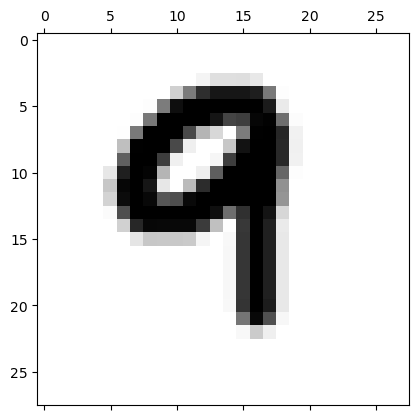

In [13]:
image = Image.open('Digit.png')
img = image.convert('L')    # converts it to greyscale
img = img.resize((28,28))
img = np.array(img)

plt.matshow(img, cmap = 'gray_r')
plt.show()

In [14]:
transform2 = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
imgtensor = transform2(img)
imgtensor=imgtensor[None,:,:]   #adding singular chanel

In [15]:
model1.eval()
with torch.inference_mode():

    output = model1(imgtensor)
    guess=(torch.max(torch.exp(output), 1)[1])[0]
    perc=torch.max(torch.exp(output)/torch.exp(output).sum())*100
    print(f'This is {guess}, and I am {perc:.1f}% confident about this')

This is 9, and I am 93.3% confident about this


---
#### $\textcolor{red}{\text{Example with Animal dataset}}$
In this case we will use colored images of animal and ask our model to tell us what animal is on the picture. We will use CIFAR10 data set.

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

trainset = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [4]:
image, label=trainset[0]
image.shape

torch.Size([3, 32, 32])

As you can see, each image is 32 by 32 pixels and has 3 channels.

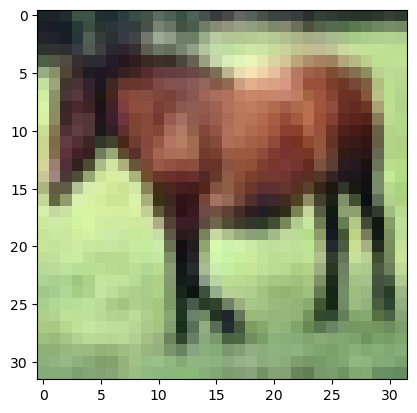

In [5]:
plt.imshow(trainset.data[7])
plt.show()

The model will be quite similar to the digit one, just different sizes. Let's add some padding as well.

In [24]:
class AnimalCNN(nn.Module):
    
    def __init__(self):
        super(AnimalCNN, self).__init__()
        self.flatten = nn.Flatten()
        self.convolution_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5,5), stride=1, padding=1),   #in = 3x32x32; out = 32x30x30
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),   # in = 32x30x30:  out = 32x15x15
            nn.Dropout(0.2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=1, padding=1),   #in = 32x15x15; out = 64x15x15
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3,3))      # in = 64x15x15:  out = 64x5x5
        )
        self.linear_stack=nn.Sequential(
            nn.Linear(64*5*5, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512,10)
        )

    def forward(self, x):
        x = self.convolution_stack(x)
        x=self.flatten(x)
        x=self.linear_stack(x)
        return x

In [25]:
model2=AnimalCNN()

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.01, momentum =0.9)

<div class="alert alert-block alert-warning"><b>Warning:</b> Careful with running training. I'm using 10 epochs here and on a decent computer it still takes about 10 minutes. If it runs too long for you, you can stop it by clicking Stop Button (square) on top. You can reduce number of epochs to 5 if you wish.</div>

In [26]:
n_epochs=10
train_loss = []
test_loss = []
train_acc=[]
test_acc=[]

In [27]:
%%time

for epoch in range(n_epochs):
    model2.train()
    for idx, (images, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        output = model2(images)
        loss=loss_func(output, labels)
        loss.backward()
        optimizer.step()


    model2.eval()
    with torch.inference_mode():
        acc, loss = get_acc_loss(model2, trainloader)
        train_acc.append(acc)
        train_loss.append(loss)
        
        acc, loss = get_acc_loss(model2, testloader)            
        test_acc.append(acc)
        test_loss.append(loss)


  #  if epoch%10==9:
    print(f'Epoch {epoch+1}/{n_epochs}, Test Loss={loss.item():.3}, Test Accuracy={acc:.3}')

Epoch 1/10, Test Loss=1.76, Test Accuracy=51.0
Epoch 2/10, Test Loss=0.719, Test Accuracy=63.4
Epoch 3/10, Test Loss=0.655, Test Accuracy=67.1
Epoch 4/10, Test Loss=0.693, Test Accuracy=70.6
Epoch 5/10, Test Loss=1.24, Test Accuracy=71.3
Epoch 6/10, Test Loss=0.264, Test Accuracy=73.1
Epoch 7/10, Test Loss=0.774, Test Accuracy=74.6
Epoch 8/10, Test Loss=0.914, Test Accuracy=75.2
Epoch 9/10, Test Loss=1.07, Test Accuracy=75.2
Epoch 10/10, Test Loss=0.86, Test Accuracy=74.4
CPU times: total: 1h 38min 1s
Wall time: 6min 7s


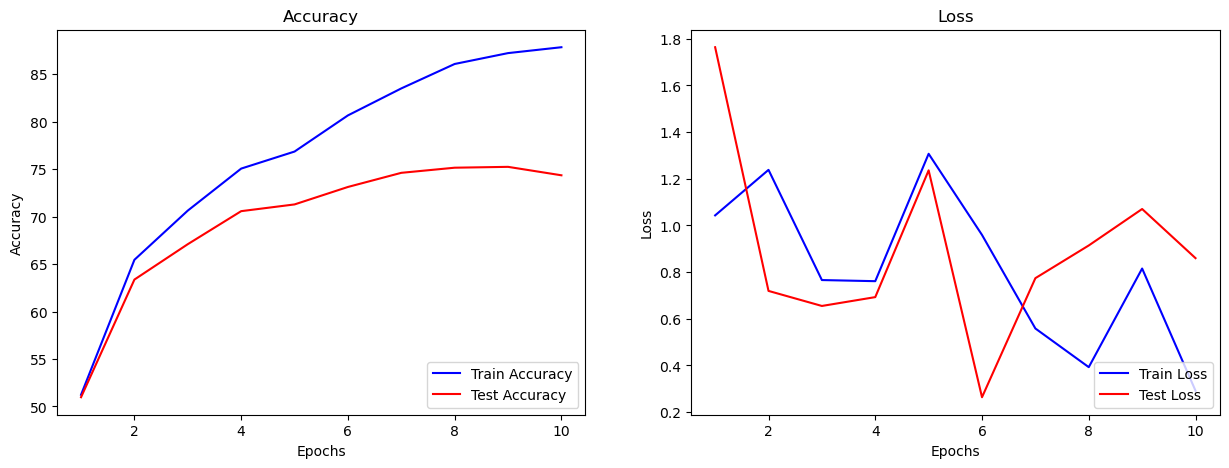

In [28]:
plot_acc_loss(train_acc, train_loss, test_acc, test_loss, n_epochs)

We got almost 75% accuracy. Not bad considering there are 10 classes and each image is quite small. We do seem to have a bit of overfit. So this still can be improved.

Remember you can save the model, so you dont have to re-run the whole training.

In [29]:
torch.save(model2.state_dict(), '.\AnimalCNNExample.pth')

In [30]:
#model2=AnimalCNN()
#model2.load_state_dict(torch.load('AnimalCNNExample.pth'))

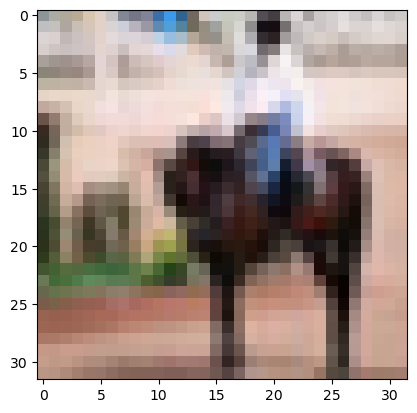

In [31]:
index=11
plt.imshow(trainset.data[index])
plt.show()

For fun let's see how our model "sees" these images. Here is what they look after first convolution

In [32]:
X = torch.tensor([trainset.data[index]], dtype=torch.float32).permute(0,3,1,2)
model2.eval()
with torch.no_grad():
    feature_maps = model2.convolution_stack[0](X)

C:\Users\Oleg\AppData\Local\Temp\ipykernel_17400\3130029316.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:277.)
  X = torch.tensor([trainset.data[index]], dtype=torch.float32).permute(0,3,1,2)


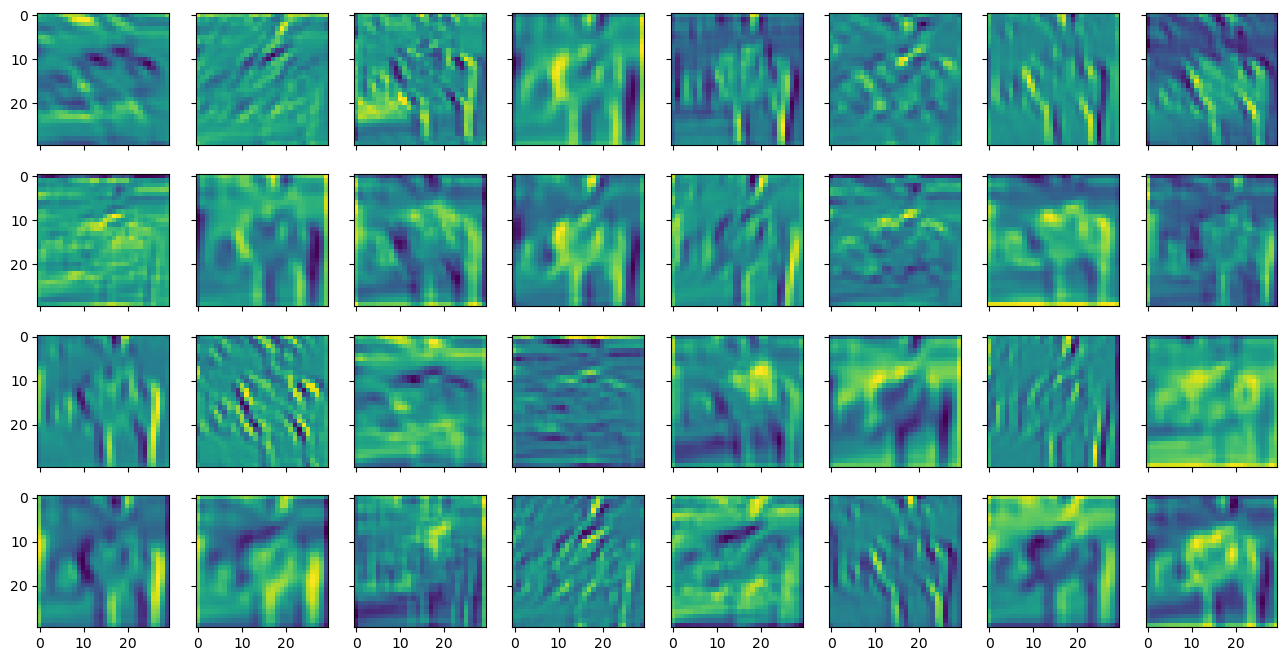

In [33]:
fig, ax = plt.subplots(4, 8, sharex=True, sharey=True, figsize=(16,8))
for i in range(0, 32):
    row, col = i//8, i%8
    ax[row][col].imshow(feature_maps[0][i])
plt.show()

And this is after second convolution

In [46]:
model2.eval()
with torch.no_grad():
    feature_maps = model2.convolution_stack[0](X)   #conv 1
    feature_maps=model2.convolution_stack[1](feature_maps) #ReLU
    feature_maps=model2.convolution_stack[3](feature_maps) # MaxPool
    feature_maps=model2.convolution_stack[4](feature_maps) #conv 2  (skipping drop out)
    feature_maps=model2.convolution_stack[5](feature_maps) # ReLU
    feature_maps=model2.convolution_stack[6](feature_maps) #MaxPool

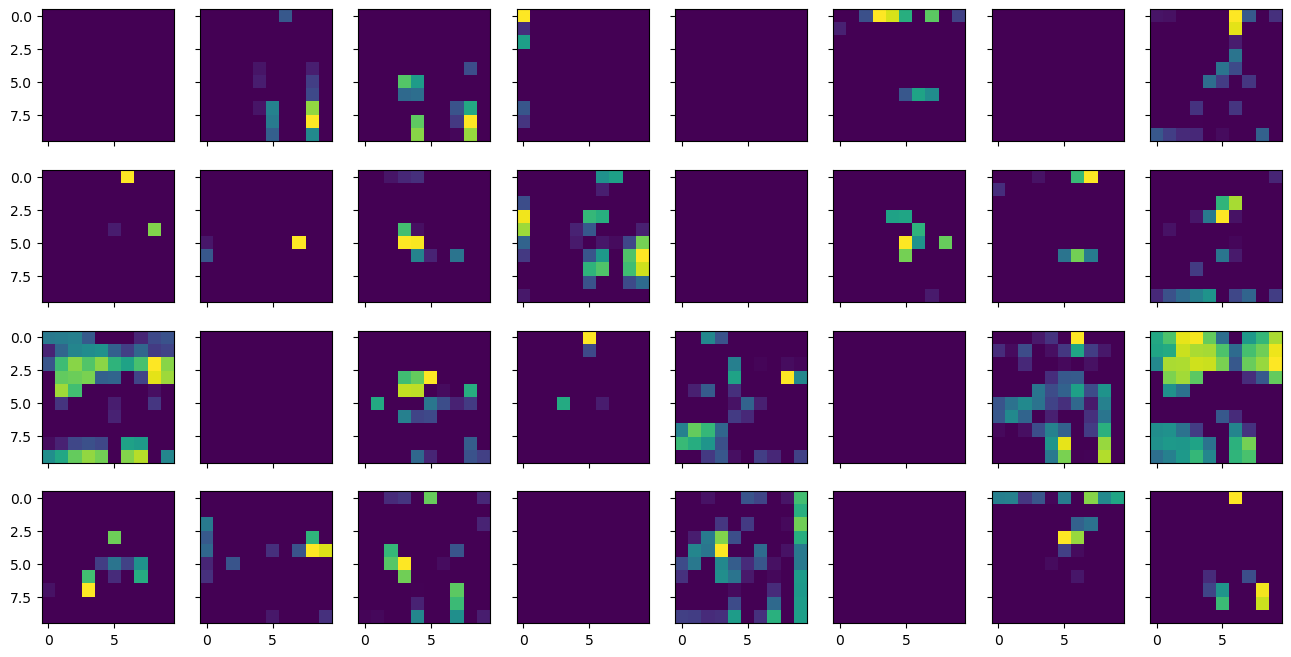

In [47]:
fig, ax = plt.subplots(4, 8, sharex=True, sharey=True, figsize=(16,8))
for i in range(0, 32):
    row, col = i//8, i%8
    ax[row][col].imshow(feature_maps[0][i])
plt.show()

Let's look at some predictions:

In [48]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [49]:
index=6
imgtensor= torch.tensor([testset.data[index]], dtype=torch.float32).permute(0,3,1,2)

model2.eval()
with torch.inference_mode():
    output = torch.softmax(model2(imgtensor), dim=1)
    guess=(torch.max(output, 1)[1])[0]

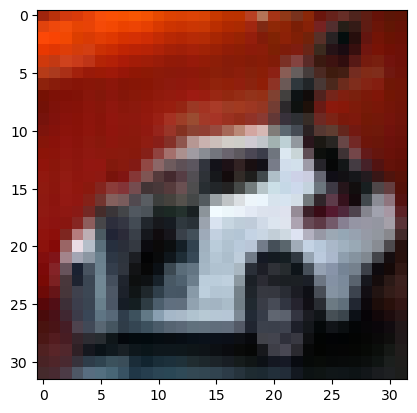

Prediction: car || True Value: car


In [50]:
plt.imshow(testset.data[index])
plt.show()
print(f'Prediction: {classes[guess]} || True Value: {classes[testset[index][1]]}')

Let's upload a random cat:

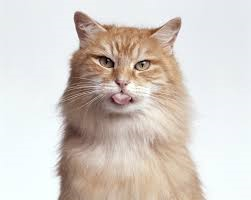

In [51]:
img = Image.open('cat.png')
img

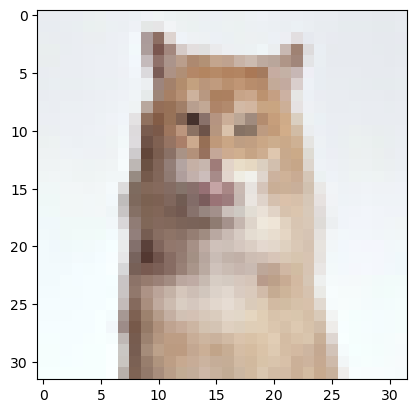

In [52]:

img = img.resize((32, 32))
img = np.array(img)
img = img[:, :, :3]  # png has 4 chanels, so I am removing one.
plt.imshow(img)
plt.show()

In [53]:

imgtensor = transform(img)
imgtensor = imgtensor.unsqueeze(0)
model2.eval()
with torch.inference_mode():
    output = torch.softmax(model2(imgtensor), dim=1)
    guess=(torch.max(output, 1)[1])[0]
print(f'Prediction: {classes[guess]}')

Prediction: cat
